# Problem Sheet 3 PDS

## Pre-Amble

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
import pandas as pd
from scipy.special import gamma
from scipy.stats import chi2

plt.style.use("/home/jhughes2712/projects/coursework/mphildis-coursework/mphil.mplstyle")

## Question 1.d.

In [36]:
def rej_sample(pdf, n, lim, max_jobs=1e6):
    """Generates a random sample from any given distribution using rejection sampling.

    Args:
        pdf (function): returns the value of the pdf of the distribution given a float input. Need not be normalised, just nonnegative.
        n (int): number of samples to realise.
        lim (tuple): gives the support of the pdf in the form (a,b).
    """
    a, b = lim
    x_vals = np.linspace(a,b,1001)
    y_max = np.max(np.vectorize(pdf)(x_vals))
    sample = []
    jobs = 0
    while len(sample) < n and jobs < max_jobs:
        x = np.random.uniform(a, b)
        y = np.random.uniform(0, y_max)
        if y < pdf(x):
            sample.append(x)
        jobs += 1
    return sample, jobs

In [41]:
def compute_d_value(k, a, b):
    return (b**k - a**k)/k

def quad_pdf(x, alpha, beta, a, b):
    N = 1/(compute_d_value(1, a, b) + alpha*compute_d_value(2, a, b) + beta*compute_d_value(3, a ,b))
    support_indicator = (x >= a)*(x <= b)
    f = N * (1 + alpha*x + beta*(x**2)) * support_indicator
    return f

In [95]:
quad_pdf_fixed = lambda x: quad_pdf(x, -1, 2, 0, 1)
quad_pdf_sample = np.array(rej_sample(quad_pdf_fixed, 10000, (0,1), max_jobs=1e10)[0])

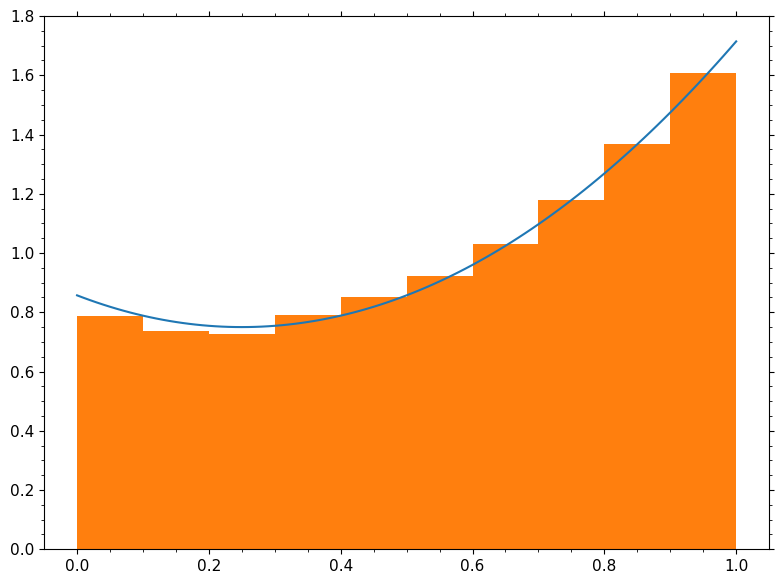

In [96]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes()

x_plot = np.linspace(0,1,101)
ax.plot(x_plot, quad_pdf_fixed(x_plot))
ax.hist(quad_pdf_sample, density=True)

plt.show()

## Question 1.e.

In [97]:
def estimate_parameters_mom(mu_1, mu_2, a, b):
    d_vals = [0]+[compute_d_value(k, a, b) for k in range(1,6)]
    alpha_hat = ((mu_1*d_vals[1] - d_vals[2])*(mu_2*d_vals[3] - d_vals[5]) + (d_vals[3] - mu_2*d_vals[1])*(mu_1*d_vals[3] - d_vals[4])) / ((mu_1*d_vals[2] - d_vals[3])*(d_vals[5] - mu_2*d_vals[3]) + (mu_2*d_vals[2] - d_vals[4])*(mu_1*d_vals[3] - d_vals[4]))
    beta_hat = (d_vals[2] - mu_1*d_vals[1] + (d_vals[3] - mu_1*d_vals[2])*alpha_hat) / (mu_1*d_vals[3] - d_vals[4])
    return alpha_hat, beta_hat

In [98]:
mu_1 = np.mean(quad_pdf_sample)
mu_2 = np.mean(quad_pdf_sample**2)
alpha_hat, beta_hat = estimate_parameters_mom(mu_1, mu_2, 0, 1)

In [99]:
model = lambda x, alpha, beta: quad_pdf(x, alpha, beta, 0, 1)
nll = cost.UnbinnedNLL(quad_pdf_sample, model )
mi  = Minuit(nll, alpha=0, beta=0)
mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -754.8                     │              Nfcn = 68               │
│ EDM = 1.57e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha │   -0.79   │   0.14    │            │            │         │         │       │
│ 1 │ beta  │   1.90    │   0.13    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────┐
│       │   alpha    beta │
├───────┼─────────────────┤
│ alpha │    0.02 -0.0157 │
│  beta │ -0.0157  0.0161 │
└───────┴─────────────────┘

In [100]:
print("MLE estimates: alpha = {:.5f}; beta = {:.5f}".format(*mi.values))
print("MOM estimates: alpha = {:.5f}; beta = {:.5f}".format(alpha_hat, beta_hat))

MLE estimates: alpha = -0.78651; beta = 1.90270
MOM estimates: alpha = -0.79903; beta = 1.91150


In [105]:
N = len(quad_pdf_sample)

cov_x11 = 1/(N*(N-1)) * np.sum( (quad_pdf_sample - mu_1) * (quad_pdf_sample - mu_1) )
cov_x12 = 1/(N*(N-1)) * np.sum( (quad_pdf_sample - mu_1) * (quad_pdf_sample**2 - mu_2) )
cov_x22 = 1/(N*(N-1)) * np.sum( (quad_pdf_sample**2 - mu_2) * (quad_pdf_sample**2 - mu_2) )

cov_paramater_estimates = np.array( [ [cov_x11, cov_x12], [ cov_x12, cov_x22] ] )

from jacobi import propagate

theta = lambda p: np.array([ *estimate_parameters_mom(*p) ])

mom, mom_cov = propagate( theta, [alpha_hat, beta_hat], cov_paramater_estimates)

ModuleNotFoundError: No module named 'jacobi'

## Question 3.a.

In [99]:
neutrino_df = pd.DataFrame({"Events":np.arange(10), "Intervals":np.array([1042, 860, 307, 78, 15, 3, 0, 0, 0, 1])})
neutrino_df

,Events,Intervals
0,0,1042
1,1,860
2,2,307
3,3,78
4,4,15
5,5,3
6,6,0
7,7,0
8,8,0
9,9,1


In [100]:
poisson_pdf = lambda x, param: param**x * np.exp(- param) / gamma(x+1)

In [101]:
neutrino_df["Expected_1"] = poisson_pdf(neutrino_df["Events"], 0.777103209) * 2306
chi_squared_1 = np.sum(((neutrino_df["Intervals"] - neutrino_df["Expected_1"])**2 ) / neutrino_df["Expected_1"])
print("Chi-squared/d.o.f.: ", chi_squared_1/9)
p_value_2 = 1 - chi2.cdf(chi_squared_1, 9)
print("P-value: ", p_value_2)

Chi-squared/d.o.f.:  368.1377242399481
P-value:  0.0


In [102]:
neutrino_df["Intervals_adj"] = neutrino_df["Intervals"].copy()
neutrino_df.iloc[-1,-1] = 0

In [103]:
neutrino_df["Expected_2"] = poisson_pdf(neutrino_df["Events"], 0.7735357918) * 2306
chi_squared_2 = np.sum( ((neutrino_df["Intervals_adj"] - neutrino_df["Expected_2"])**2 ) / neutrino_df["Expected_2"] )
print("Chi-squared/d.o.f.: ", chi_squared_2/9)
p_value_2 = 1 - chi2.cdf(chi_squared_2, 9)
print("P-value: ", p_value_2)

Chi-squared/d.o.f.:  0.3604574572354266
P-value:  0.9538250128893228


In [106]:
chi_squared_1, chi_squared_2

(3313.239518159533, 3.2441171151188395)

In [105]:
neutrino_df

,Events,Intervals,Expected_1,Intervals_adj,Expected_2
0,0,1042,1060.150854,1042,1063.939608
1,1,860,823.846630,860,822.995367
2,2,307,320.106930,307,318.308187
3,3,78,82.918708,78,82.074258
4,4,15,16.109098,15,15.871844
5,5,3,2.503686,3,2.455488
6,6,0,0.324270,0,0.316568
7,7,0,0.035999,0,0.034982
8,8,0,0.003497,0,0.003383
9,9,1,0.000302,0,0.000291
